# TM10007 Assignment

---



In [0]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

Import modules

In [0]:
# Data loading function
from brats.load_data import load_data

# General packages
import numpy as np
import pandas
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn import model_selection

# Classifiers and kernels
from sklearn import neighbors
from scipy import stats
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn import feature_selection 
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel, sigmoid_kernel
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Regularization
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from time import time

# Functions for plotting ROC curve
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

Functions

In [0]:
#@title Default title text

# Preprocessing: fill missing data
def missing_data(X_train,Y_train):
    # Fill by KNN Imputer
    imputer_KNN = KNNImputer(n_neighbors=2, weights="uniform")
    X_train_KNN_imputed = imputer_KNN.fit_transform(X_train)
    X_test_KNN_imputed = imputer_KNN.fit_transform(X_test)
    return X_train_KNN_imputed,X_test_KNN_imputed 

# Preprocessing: feature scaling (standard scaling)
def standard_scaler(X_train_KNN_imputed, X_test_KNN_imputed):
    # Set standard scaler
    scaler = preprocessing.StandardScaler()
    scaler.fit(X_train_KNN_imputed)
    X_train_scaled = scaler.transform(X_train_KNN_imputed)
    X_test_scaled = scaler.transform(X_test_KNN_imputed)
    return X_train_scaled, X_test_scaled

def split_data(data, data_label):
    # Split the dataset in train (70%) and test part (30%)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(data, data_label, test_size=0.3, stratify=(data_label))

    # Give new indexes to samples
    X_train = X_train.reset_index()
    X_train = X_train.drop(columns=['index'])
    X_test = X_test.reset_index()
    X_test = X_test.drop(columns=['index'])
  
    # Remove the label columns from the train and the test data
    X_train = X_train.drop(columns=["label"])
    X_test = X_test.drop(columns=["label"])

    # Print number of samples in both sets
    print(f'The number of samples in the training set: {len(X_train.index)}')
    print(f'The number of samples in the test set: {len(X_test.index)}')
    return(X_train, X_test, y_train, y_test)
    
# Feature selection: PCA
def pca(X_train_scaled, X_test_scaled):
    # Train and plot Principal Component Analysis
    
    pca = PCA().fit(X_train_scaled)
    fig2, ax2 = plt.subplots()
    ax2.plot(np.cumsum(pca.explained_variance_ratio_))
    ax2.set_title('Prinicpal Component Analysis')
    ax2.set_xlabel('Number of components')
    ax2.set_ylabel('Cumulative explained variance')

    # Apply PCA to keep 98% of the variance = 70 components
    pca = PCA(n_components=70)
    pca.fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    return X_train_pca, X_test_pca

# Plot ROC curve
def plot_roc_curve(y_score, y_truth):
    '''
    Plot an ROC curve.
    '''
    # Only take scores for class = 1
    y_score = y_score[:, 1]
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_truth, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc

# Feature selection: recursive feature elimination
def rfecv_featureselection(X_train, X_test, y_train):
    from sklearn import feature_selection 

    # Create the SVC classifier
    svc = svm.SVC(kernel="linear")

    # Recursive feature elimination
    rfecv = feature_selection.RFECV(estimator=svc, step=1, 
                                cv=model_selection.StratifiedKFold(10), 
                                scoring='roc_auc')
    rfecv.fit(X_train, y_train)
    X_train_rfecv = rfecv.transform(X_train)
    X_test_rfecv = rfecv.transform(X_test)

    # Plot number of features VS. cross-validation scores
    fig2, ax1 = plt.subplots()
    ax1.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    ax1.set_title('Recursive feature elimination')
    ax1.set_xlabel("Number of features selected")
    ax1.set_ylabel("Cross validation score (nb of correct classifications)")
    print(X_train_rfecv.shape)
    return X_train_rfecv, X_test_rfecv

# L1 (LASSO) Regularization
def regularization_lasso(X_train, X_test, y_train, y_test):
    # Display the weights and compute error for multiple values for alpha
    n_alphas = 200
    alphas = np.logspace(-10, 1, n_alphas)
    # Construct classifiers
    coefs = []
    accuracies = []
    times = []
    for a in alphas:
        # Fit classifier
        clf = Lasso(alpha=a, fit_intercept=False)
        t0 = time()
        clf.fit(X_train, y_train)
        duration = time() - t0
        y_pred = clf.predict(X_test)
        message = ("\t Misclassified: %d / %d" % ((y_test != y_pred).sum(), y_test.shape[0]))
        print(message)
        
        # Append statistics
        accuracy = float((y_test != y_pred).sum()) / float(y_test.shape[0])
        times.append(duration)
        accuracies.append(accuracy)
        coefs.append(clf.coef_)

    # #############################################################################
    # Display results

    # Weights
    plt.figure()
    ax = plt.gca()
    ax.plot(alphas, np.squeeze(coefs))
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel('alpha')
    plt.ylabel('weights')
    plt.title('Lasso coefficients as a function of the regularization')
    plt.axis('tight')
    plt.show()

    # Performance
    plt.figure()
    ax = plt.gca()
    ax.plot(alphas, accuracies)
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel('alpha')
    plt.ylabel('accuracies')
    plt.title('Performance as a function of the regularization')
    plt.axis('tight')
    plt.show()

    # Times
    plt.figure()
    ax = plt.gca()
    ax.plot(alphas, times)
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel('alpha')
    plt.ylabel('times (s)')
    plt.title('Fitting time as a function of the regularization')
    plt.axis('tight')
    plt.show()

# Select from module LASSO
def select_from_module_lasso(X_train, X_test, y_train):
    selector = SelectFromModel(estimator=Lasso(alpha=10**(-8),random_state = 42 ), threshold='median') #random_state = 42
    selector.fit(X_train, y_train)
    n_original = X_train.shape[1]
    X_train = selector.transform(X_train)
    X_test = selector.transform(X_test)
    n_selected = X_train.shape[1]
    print(f"Selected {n_selected} from {n_original} features.")
    return(X_train, X_test)

# Optimization hyperparameters KNN classifier
def optimalisation_knn(X_train, X_test, y_train, y_test):
    # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation

    # Specify the classifier
    knn = neighbors.KNeighborsClassifier()

    # Specify the search range, this could be multiple parameters for more complex classifiers
    parameters = {
        "n_neighbors": list(range(1, 8, 2))
    }


    # Create the grid search method, use area under ROC curve as scoring metric
    # Too learn more about metrics see: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    grid_search = RandomizedSearchCV(knn, parameters, cv=10, scoring='roc_auc', random_state =42)

    # Do the entire search
    grid_search.fit(X_train, y_train)

    clf_knn = grid_search.best_estimator_
    accuracy = clf_knn.score(X_test,y_test)
    y_score = clf_knn.predict_proba(X_test)
    plot_roc_curve(y_score, y_test)

    # Only take scores for class = 1
    y_score = y_score[:, 1]
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    return accuracy, roc_auc

# Optimization SVM
def optimalisatie_svm(X_train,X_test,y_train, y_test):

    Cs = [0.001, 0.01, 0.1, 1, 10]
    param_distributions = {'C': Cs}
    clf = RandomizedSearchCV(SVC(kernel='rbf'), param_distributions, cv=10, random_state=42) #random_state=42 
    
    # Fit the classifier
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test,y_test)
    y_score = clf.predict(X_test)
    
    roc_auc = metrics.roc_auc_score(y_test, y_score)
    return accuracy, roc_auc

# L1 Regularization (LASSO)
def lasso(X_train,X_test,y_train, y_test):
          
    X_train_lasso, X_test_lasso = select_from_module_lasso(X_train, X_test, y_train)

    # Fit LDA on selected features (LASSO)
    clf = LDA()
    clf.fit(X_train_lasso, y_train)
    accuracy = clf.score(X_test_lasso,y_test)
    y_score = clf.predict_proba(X_test_lasso)[:,1]
    roc_auc=metrics.roc_auc_score(y_test, y_score)
  
    return accuracy, roc_auc

# Plot learning curves
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

#learning curves 2
def learning_curve_two(X_train, X_test, y_train, y_test):

    # Define possible classifiers
    clsfs = [RandomForestClassifier(n_estimators=1, random_state = 42), #random_state = 42
             RandomForestClassifier(n_estimators=5,random_state = 42), #random_state = 42
             RandomForestClassifier(n_estimators=10,random_state = 42), #random_state = 42
             KNeighborsClassifier(n_neighbors=1),
             SVC(kernel='linear'),
             SVC(kernel='rbf', gamma='scale'), 
             SVC(kernel='poly', degree=3, gamma='scale'),
             SVC(kernel='rbf', gamma='scale',  C = 0.01),
             SVC(kernel='rbf', gamma='scale',  C= 1),
             KNeighborsClassifier(n_neighbors=4),
             KNeighborsClassifier(n_neighbors=8),
             SVC(kernel='rbf', gamma='scale',  C= 0.5),]
            

    # Cross Validation
    cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42) #random_state=42
    fig = plt.figure(figsize=(24,8))
    num = 0

    # Create learning curves
    for clf in clsfs:
        title = str(type(clf))
        ax = fig.add_subplot(4, 3, num + 1)
        plot_learning_curve(clf, title, X_train_pca, y_train, ax, ylim=(0.3, 1.01), cv=cv)
        num += 1

Load and adjust data

In [0]:
# Load data
data = load_data()

# Adjust data (replace infinity, #DIV/0 and 0 by NaN)
data = data.replace([np.inf, -np.inf], np.nan)
data = data.replace("#DIV/0!", np.nan)
data = data.replace(0, np.nan)

# Set outcome GBM=1 and LGG=0
data = data.replace("GBM", 1)
data = data.replace("LGG", 0)

# Remove ID index and replace by new index increasing from 1 to N
data = data.reset_index()
data = data.drop(columns=["ID"])

print(data)

# Print number of samples and columns (=number of features + 1)
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

     VOLUME_ET  VOLUME_NET  VOLUME_ED  ...  TGM_Cog_Z_6  TGM_T_6  label
0       1662.0         384    36268.0  ...          NaN      NaN      1
1       4362.0        4349    15723.0  ...          NaN      NaN      1
2      33404.0       48612    45798.0  ...          NaN      NaN      1
3      12114.0        7587    34086.0  ...          NaN      NaN      1
4      34538.0        7137    65653.0  ...          NaN      NaN      1
..         ...         ...        ...  ...          ...      ...    ...
162     2093.0        8685    39142.0  ...          NaN      NaN      0
163     1929.0         437    54079.0  ...          NaN      NaN      0
164     8755.0      168606    11325.0  ...     0.140121  3.17204      0
165    11757.0        1012   138755.0  ...          NaN      NaN      0
166        NaN       60154    76349.0  ...          NaN      NaN      0

[167 rows x 725 columns]
The number of samples: 167
The number of columns: 725


Outer loop

The number of features that have more than 60% missing data is 24. The following features are removed:
            column_name  missing_count
172   SPATIAL_CC_Fornix            111
173   SPATIAL_Occipital            114
174        SPATIAL_Cere            157
175  SPATIAL_Brain_stem            125
704         TGM_Cog_X_2            132
705         TGM_Cog_Y_2            132
706         TGM_Cog_Z_2            132
707             TGM_T_2            132
708         TGM_Cog_X_3            157
709         TGM_Cog_Y_3            157
710         TGM_Cog_Z_3            157
711             TGM_T_3            157
712         TGM_Cog_X_4            164
713         TGM_Cog_Y_4            164
714         TGM_Cog_Z_4            164
715             TGM_T_4            164
716         TGM_Cog_X_5            164
717         TGM_Cog_Y_5            164
718         TGM_Cog_Z_5            164
719             TGM_T_5            164
720         TGM_Cog_X_6            166
721         TGM_Cog_Y_6            166


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763308123936834, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763309693073268, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763312455043764, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763310333731106, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763311926195392, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763314111109885, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763314004178334, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763313896390319, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.76331360062282, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763315384651342, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763315244156498, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763315920291294, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763316371606876, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763316299509228, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763316138556196, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763316156131392, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763317359530202, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763317541220012, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763317381292016, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.76331795757108, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763318146337667, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763318186191295, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763318650607705, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763319057293053, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763319218337102, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763319674367683, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.76332026766045, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.76332060253906, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763321287891063, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763321981111876, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763322588148618, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763323441207298, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763324391434214, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763325418299278, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763326627494369, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763327981632607, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763329452770911, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.76333120870455, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763333146824504, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763335361180829, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.763337915877532, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.945622214471019, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.87641771935824, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.875964008002406, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.875968170906706, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.875972913266981, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.87597830675723, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.875984433098953, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.875991368481404, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.875999248233079, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.876008191735863, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.876018353825103, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.876029871076046, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.594927532975763, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.594946250232915, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.59496303064909, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.631155251193064, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.631176202667387, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.740880065278358, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.882184578914202, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.918791885093881, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.592276983447135, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.818412209814777, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.813245755157062, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.81329490435406, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.79500038310358, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.115565386261913, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.987325170869084, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.108555201980053, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.61383372160768, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.795700053994164, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.834237662403218, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.673508730660064, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.609805152607336, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.692155013627563, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.75136043851917, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.302060895340485, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.27174180478744, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.537152668653587, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.502799722222882, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.829741611479786, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.813117643748512, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.143310833333725, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.118359554359408, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.642979289270567, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.07182392673824, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.493351223214674, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.021496860067412, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.200301832708465, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.663179317969071, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.479443852332736, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.47843816324027, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.06919891217343, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.710331023290426, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.284143765991253, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.946626585815991, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.4303970891011275, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.9618683984697896, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.346509299564222, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.997327093125438, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.0579407581049765, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.779839259944389, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.608661368562334, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.9139655234470645, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.97015800187679, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.49393588240671, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1019622122743264, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3021981273868874, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.187134499311217, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.144169192372143, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4087097296719833, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.369413778002361, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.881380052005973, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7883354120191939, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.034428894965693, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6251145429351155, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2763444806962525, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9468929035536391, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9598834730563368, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5814815121768007, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5056843095408325, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5144661149508352, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3650797579474556, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13189974285490536, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09626100990597308, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08969843974990965, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0982324407774513, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13377571235454155, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08367217257627857, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01954446776419161, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


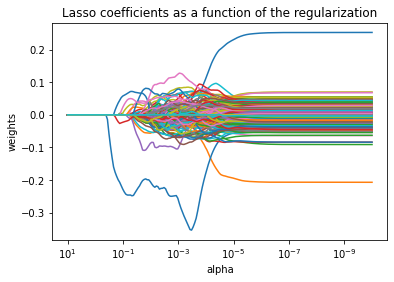

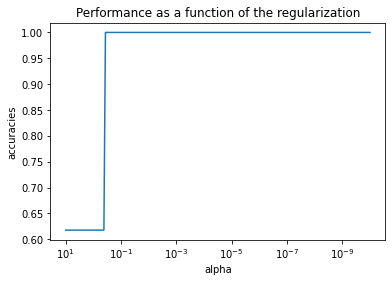

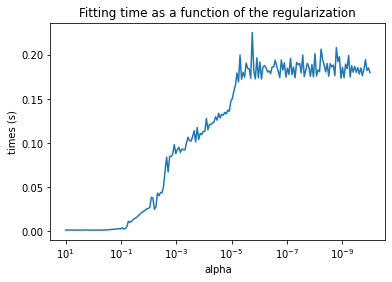

Selected 350 from 700 features.


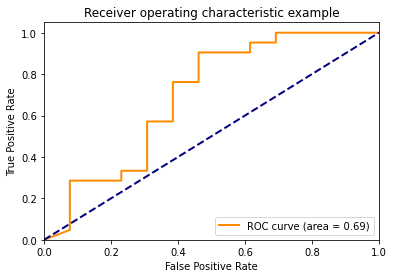

(133, 189)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


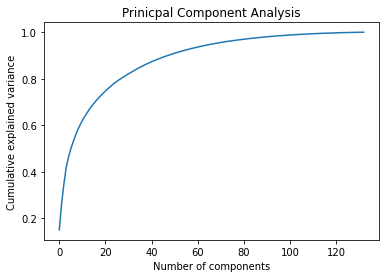

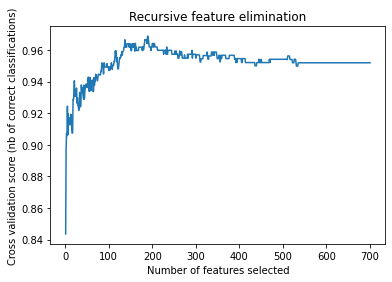

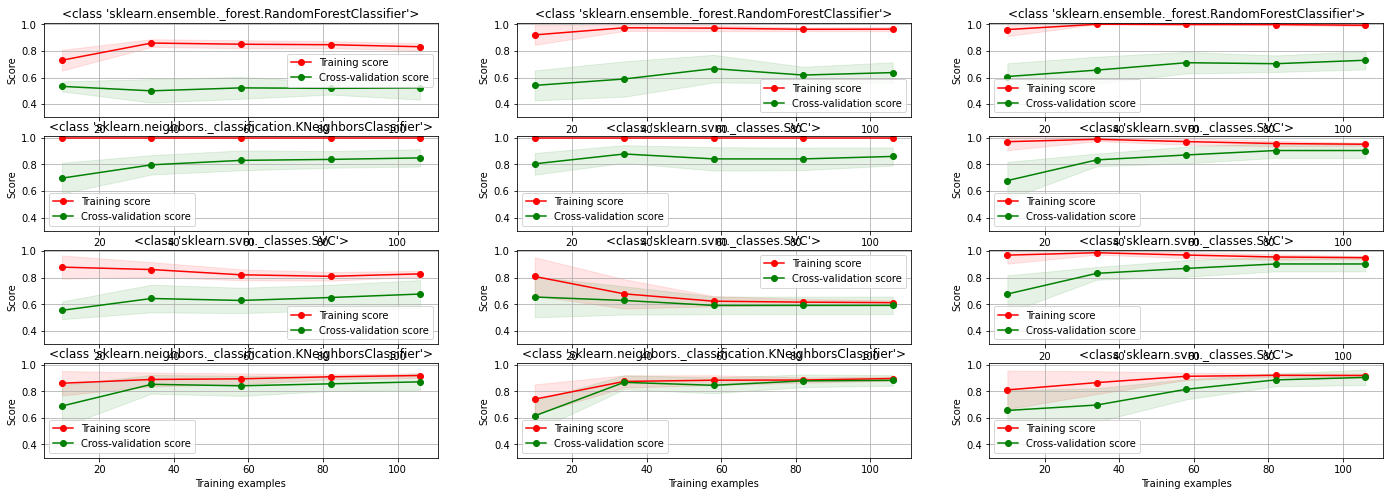

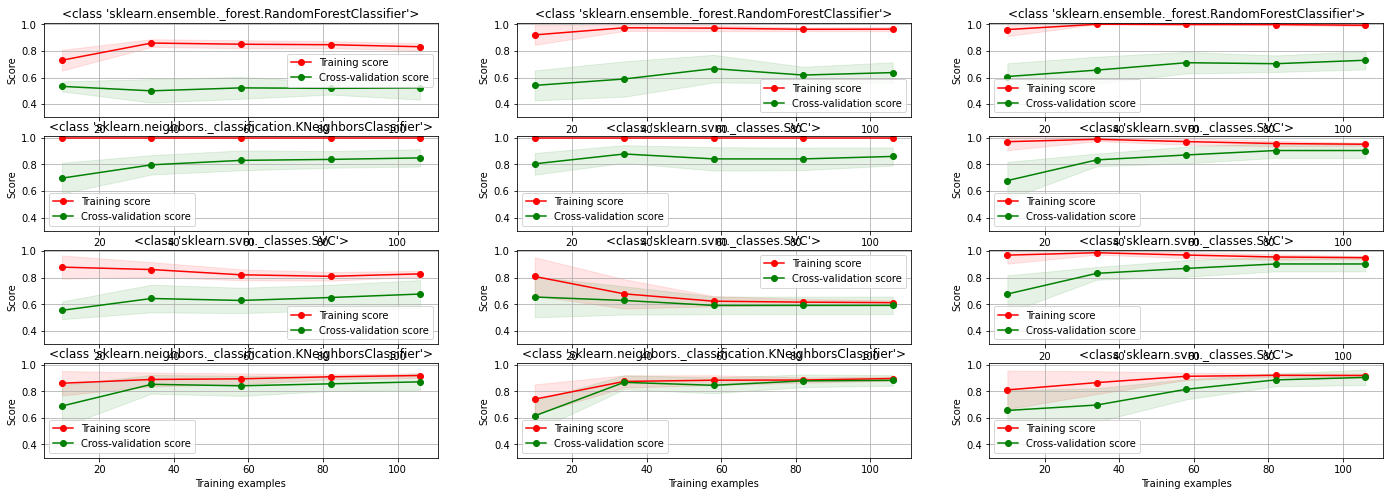

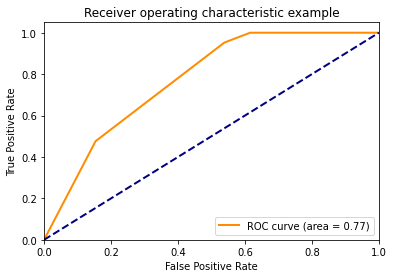

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


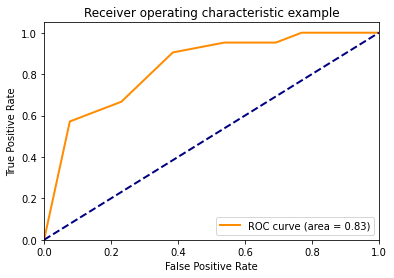

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Selected 350 from 700 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291294583159551, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291293788828009, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291297692669405, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291296268767383, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291297579470582, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291297065436892, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291297857149308, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291297549167528, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291297125152028, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291298633735583, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291297454922361, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291297892522138, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291298604457953, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291298366726647, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291298636862566, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291298881898662, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291299048372418, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291299116200658, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291299202061047, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291299295446972, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291299794238524, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291299845115118, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291300262386985, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291300509030725, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291300825882768, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291301174653745, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291301706773888, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.29130232799086, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291302807804001, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291303512897073, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291304200342383, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291305134071912, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291306097151946, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.291307149752997, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.964782020823794, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.964808093296623, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.964809655206537, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.964811469897535, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.964813539876543, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.96481585083092, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.964818500482535, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.964821490658142, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.964824893984662, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.964828766442544, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.964833151710115, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.9648381322656, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.964843790029546, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.96485020138997, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.964857473652309, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.964865738596544, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.964875111168702, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.74550903620761, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.745519799993707, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.745533455668555, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.863457639195522, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.86347522046908, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.60626322749989, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.606285770334155, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.606311339678058, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.60634030628381, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.671117465165684, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.519742076333095, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.549020687676935, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.512343932577382, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.220527767696177, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.408308078626732, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.448606303425276, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.119960494123843, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.223398289877375, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.1327408576077, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.291855720251052, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.617168696575183, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.561703635341948, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.794552086551178, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.731126313270194, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.333583294362436, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.84711971488153, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.04339993195033, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.797834323595287, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.04874074687751, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.922153155493035, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.698731715792093, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.232903708089214, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.722803772785806, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.076914388647001, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.425746954925094, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.349588069146492, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.544054051853061, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.261076251758507, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.41336100826419, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.10617948466421, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.580180503331007, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.801268849972967, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.98764544889774, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.35375965107372, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.857797041513432, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.116902735505395, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.068952241012894, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.316530102912935, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.715686852966947, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.002699369915369, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.956825024000466, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.64485924540983, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.8748368735226855, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.448984160694437, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.358238849531531, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.6077965001782175, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.843485725855885, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.720143412206479, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7331172336194456, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.507055684739367, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3550492402980723, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8655203297380325, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.726203630964072, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.367631351174765, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2517678679284643, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1662334347162968, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8965220457380383, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7070300086662797, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6874792282341389, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20611166175569196, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.225073337294333, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14529317581983747, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.038750992278117735, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.040085181392171876, tolerance: 0.0081
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013638671391284163, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008602323243692922, tolerance: 0.0081
  positive)


	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34
	 Misclassified: 34 / 34


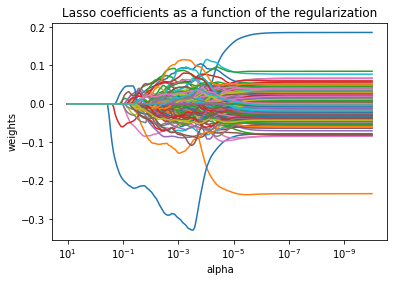

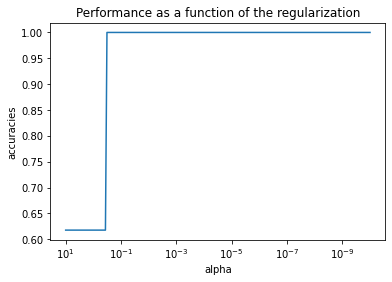

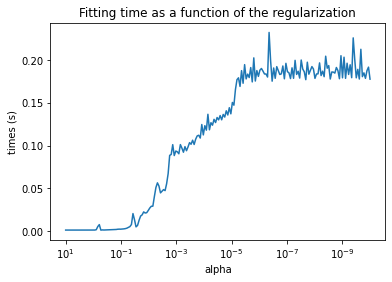

Selected 350 from 700 features.


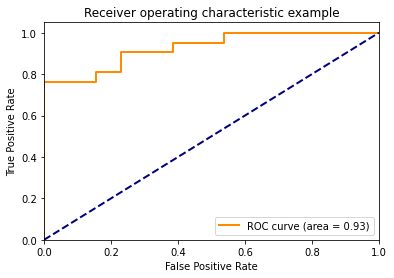

(133, 115)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


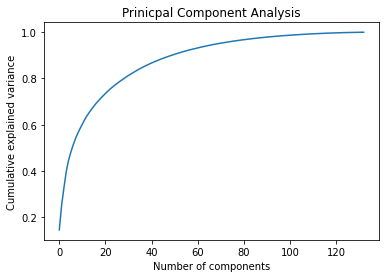

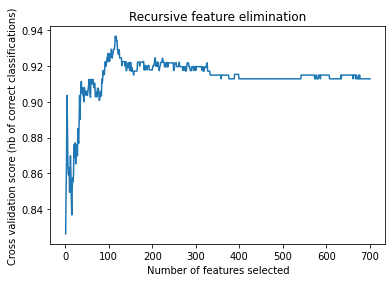

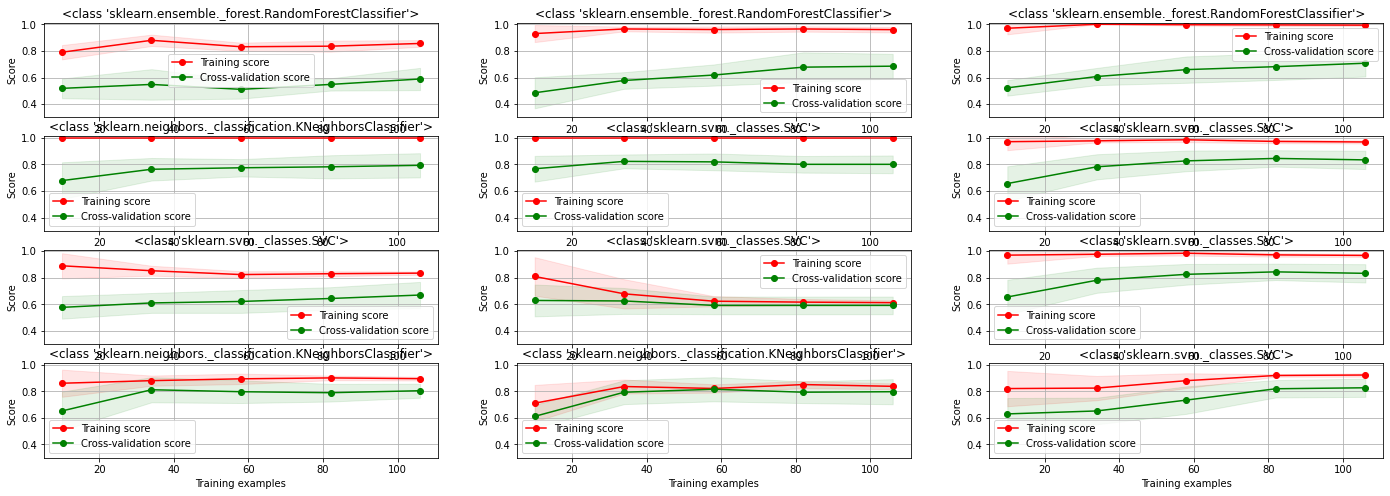

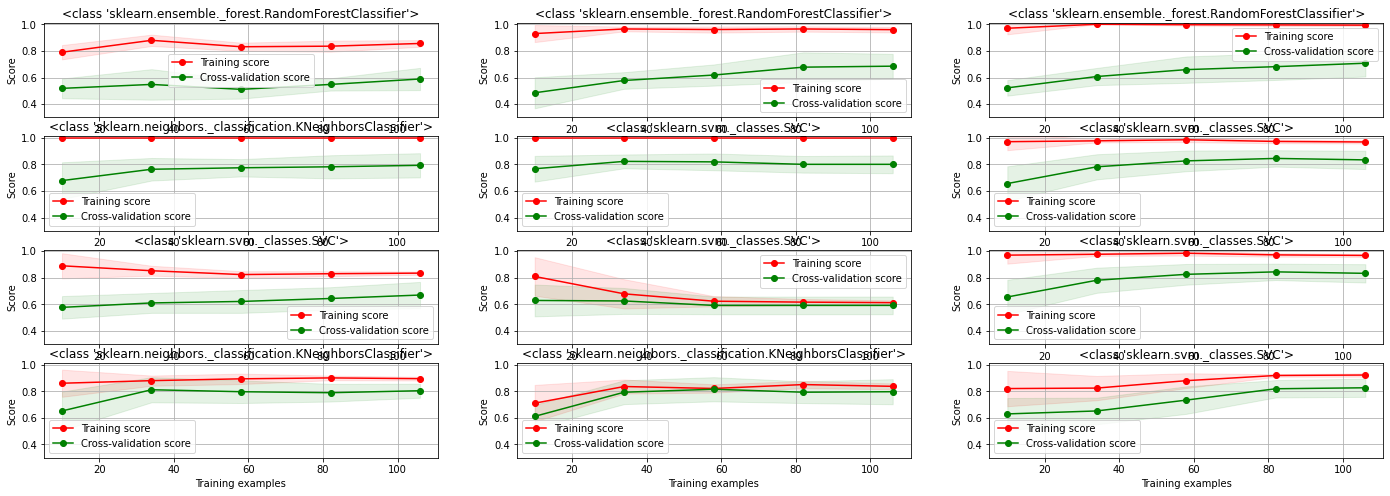

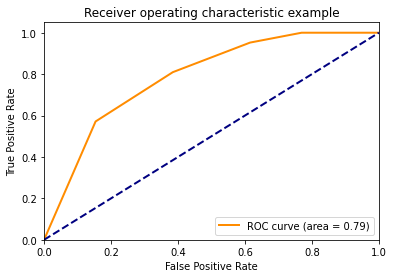

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


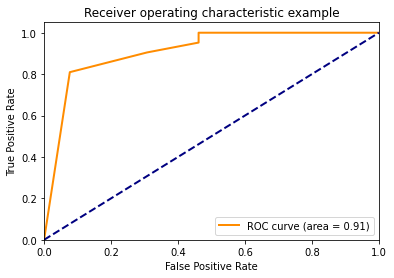

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Selected 350 from 700 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789211791909494, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789210701045956, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789214476049558, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789212222096758, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789213129758089, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.78921431253842, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789214515426506, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789214079106285, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789216558819675, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789216379577368, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789216271595963, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789216702250611, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789217530917261, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.7892173366932, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789217006216186, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.78921768921722, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789217908845114, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789218215608145, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789218243093597, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.78921840773843, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789218803460972, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789219186803718, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789219361684378, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789219687165318, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.78922003693371, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789220640993356, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789220945256794, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.78922150524618, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789222133904726, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.78922293196142, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789223688065972, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789224569205697, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789225622377499, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.78922675058713, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789228106809619, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789229520834674, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789231203929498, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789233111251358, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789235266795277, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789237706748343, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789240493715013, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789243637328836, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.78924722773663, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.789251289459706, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.727316681145624, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.728268092592693, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.728274041723065, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.72828079011831, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.728288446366983, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.728297141111012, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.728307005545254, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.728318196453985, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.728330902348524, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.70225137226717, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.697767330356335, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.697963745658267, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.614163020163112, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.615503543416164, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.42007773088409, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.602423266312604, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.56710885490595, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.567148807286987, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.560255130557366, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.377211474714363, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.52882302982958, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.39724505327106, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.366927674739598, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.181544346438397, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.164870412819326, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.169024074388291, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.2273479020614, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.139792943309812, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.3773996385149, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.284911006990795, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.433688488369466, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.44050412345559, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.759995785852334, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.906316462935244, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.029554814182012, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.446133250095585, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.378038140273649, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.073806908670878, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.399106773105927, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.692515748141147, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.508550974477355, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.346674954802324, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.498730183309853, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.818511220845075, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.196032229391193, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.073750646862923, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.467176784525119, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.538174795146954, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.350186868440375, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.585549148105276, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.336580461632366, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.6287703085396465, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.666734951989877, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.306667653510182, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.160310597830488, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.113787471023048, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.020151275009567, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.323453224788157, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.438660423925093, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.795088725773205, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.940927039691232, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.0645650611754505, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.032979574303717, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.036567538643613, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9977194724763123, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.184160818961029, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6990458357204687, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.935000126947621, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5786107663964515, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6882736601190516, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5756423579828862, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4733707194076047, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8055675391223289, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5874755676682142, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24504324026911206, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23716334284365104, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.27934479073080354, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23530442932319318, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10107875142309553, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06067819149566844, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.062373351361245, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06000213715920921, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.056850861042939016, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04389892055716871, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028506088708084576, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02001461155737161, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01012015259100707, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


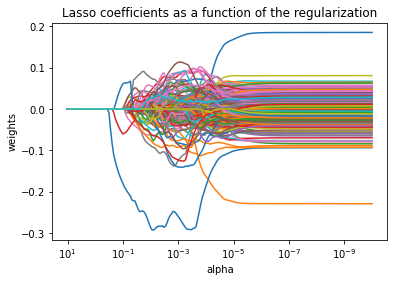

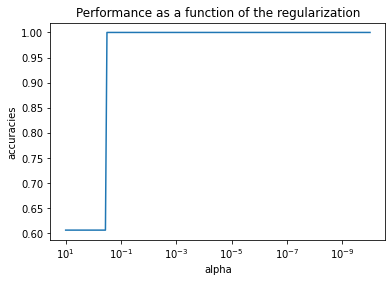

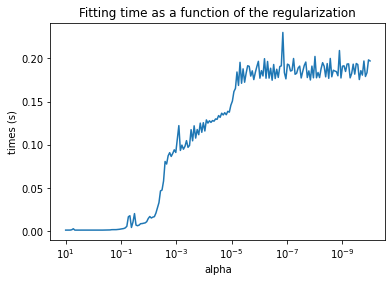

Selected 350 from 700 features.


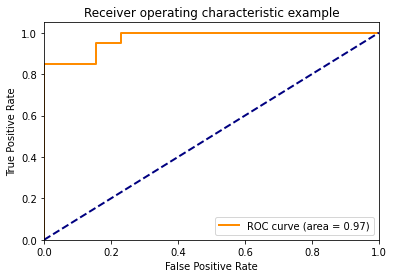

(134, 69)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


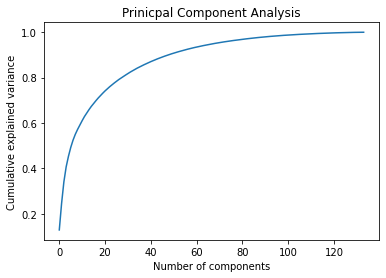

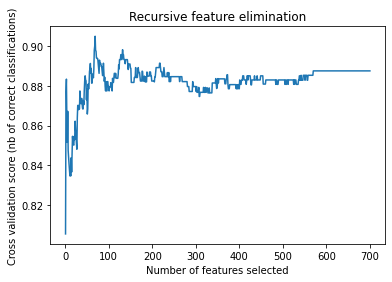

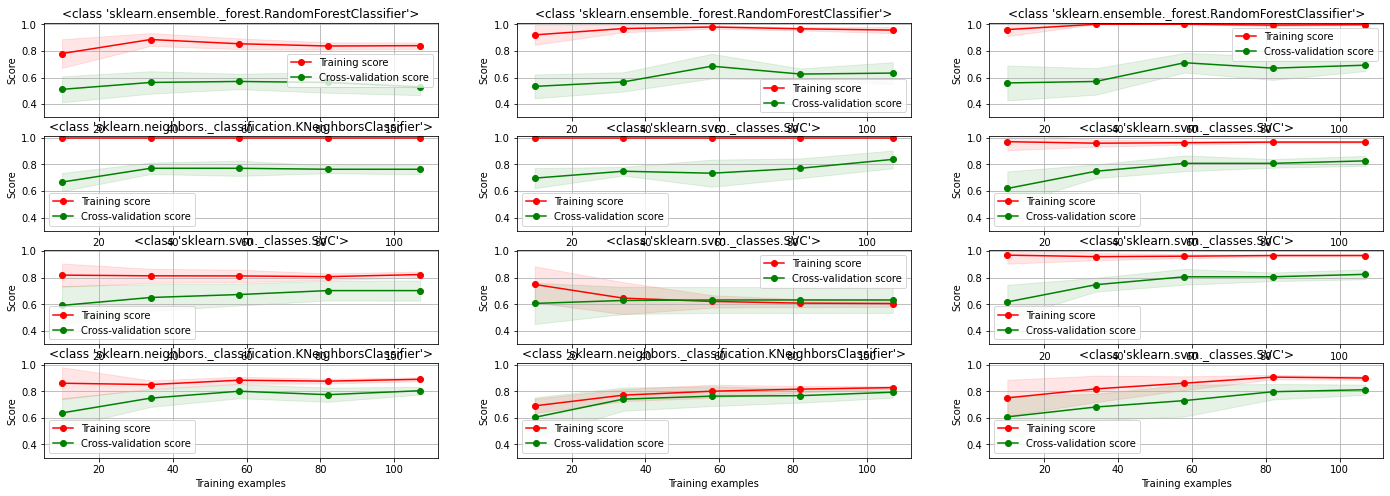

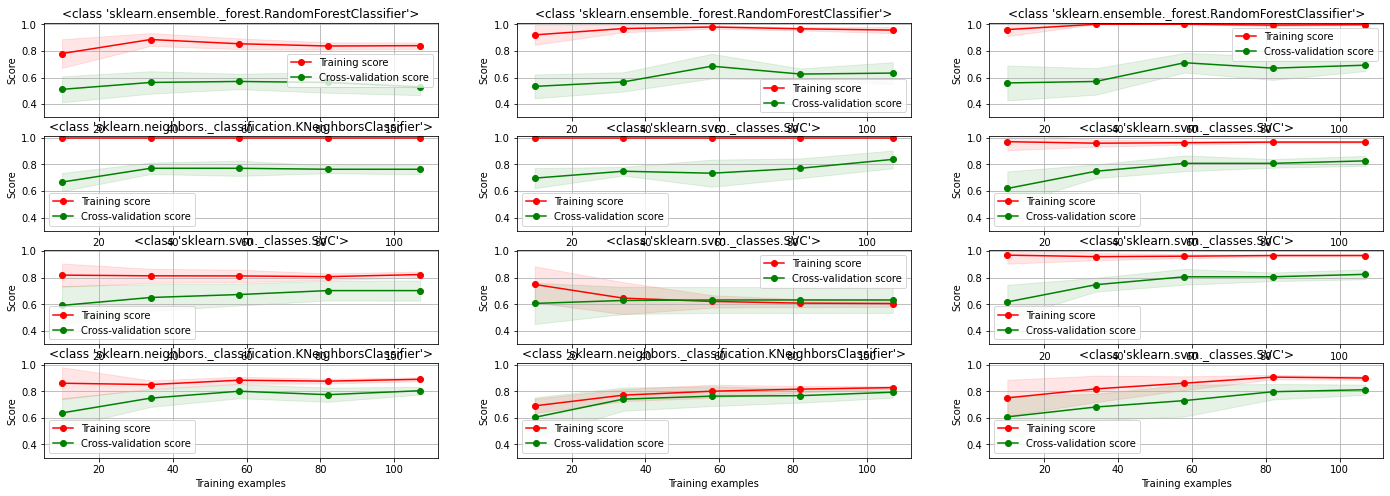

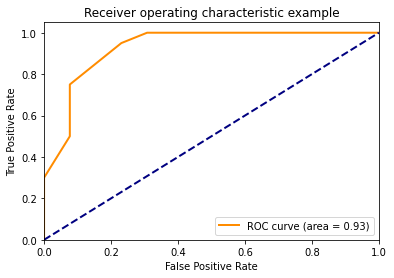

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


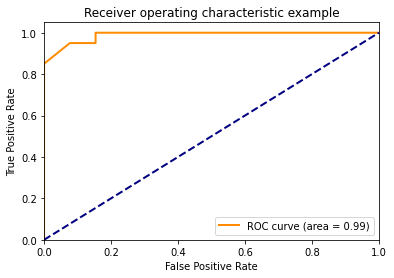

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Selected 350 from 700 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.756119912304797, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.756112618033944, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.75611690351813, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.756117292060976, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.756114156660459, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.75611503235096, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.756110463621566, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.756109849202582, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.75610959971575, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.756106022820687, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.756107288670194, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.756108432637827, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.756106292474449, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.756106467100317, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.756106082526083, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.756105810572594, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.756105637906897, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.756105895747254, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.756105261728248, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.756105426708128, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.756105308970277, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.756105125533177, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.75610534378919, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.756105448132676, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.756105784710089, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.756106106633142, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.862743105000224, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.862667997031103, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.862668630364409, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.862669152265411, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.862669864187271, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.862670733653491, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.862671644981233, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.862672713179666, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.80581315633799, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.805863474846099, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.805865096628503, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.805866884105518, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.683247313584413, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.732478193648538, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.732480916938568, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.732483949108804, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.732487418265197, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.732491345793, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.732495810261076, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.732500885464317, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.732506642242914, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.732513183691099, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.732520613734948, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.705100236282915, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.705349426068135, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.705360279606191, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.705372599884619, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.705386577105523, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.911094501867257, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.911112753890581, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.350866420772645, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.14420346296887, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.175451353475392, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.175480626723019, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.175514320675502, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.228503970919004, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.350039162288153, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.386960810877511, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.396213147289, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.320057543053558, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.11074345675397, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.389420415385803, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.792110509281454, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.746612391213233, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.746652637935144, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.86849826755523, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.939727740485697, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.317201717151905, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.335410068080344, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.10009488572267, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.731394552841845, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.036828763769464, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.72887818745334, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.82612805083876, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.998865179787582, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.473203767102584, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.613108581747131, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.07803077484263, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.061249339871829, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.745406174354244, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.335025256623261, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.373046817362871, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.37499696941111, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.506924314168707, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.642614280819839, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.421029792340358, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.645407435162085, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.47711015897829, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.696075705440336, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.8939831515769, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.458773449554304, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.372296721567032, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.272051906006418, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.7740402780512525, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.053910340532909, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.305070440844219, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.305009488751697, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.5181863060824945, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.359945128650729, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.384877770155214, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.688189225652504, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.2320853963481575, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.866740691948806, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1172226678672814, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4934615395493367, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8006785466596007, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.355600929943215, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.149109460454845, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4839095483254496, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2844842899297504, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2132075410663035, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5126096289386624, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9958104695459582, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6285054707410964, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3589254403467308, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6043365227021198, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4899943158790876, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.37308914030719365, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2810984662646945, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2703586140600507, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2266179516193958, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10814663831778404, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.042527146384422565, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.034953864461577666, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013559623914865426, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


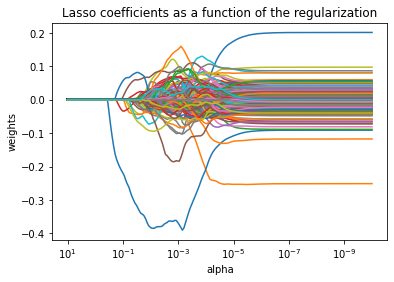

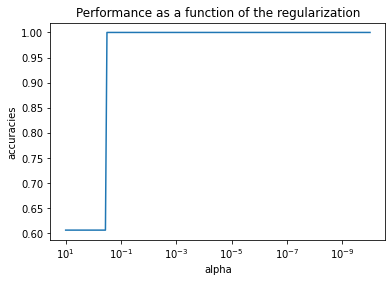

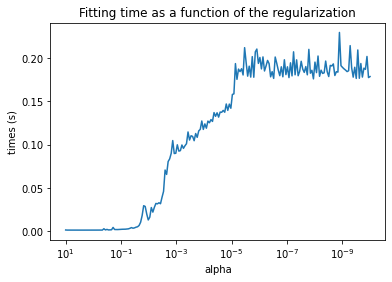

Selected 350 from 700 features.


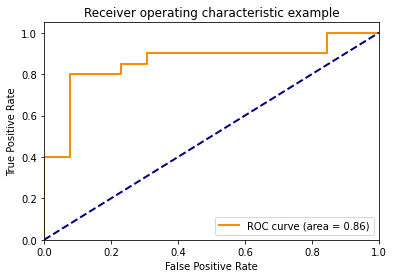

(134, 37)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


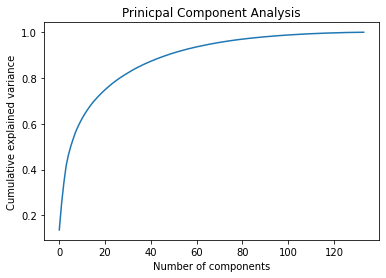

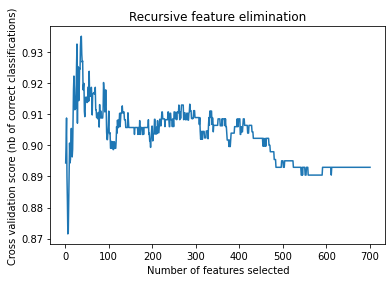

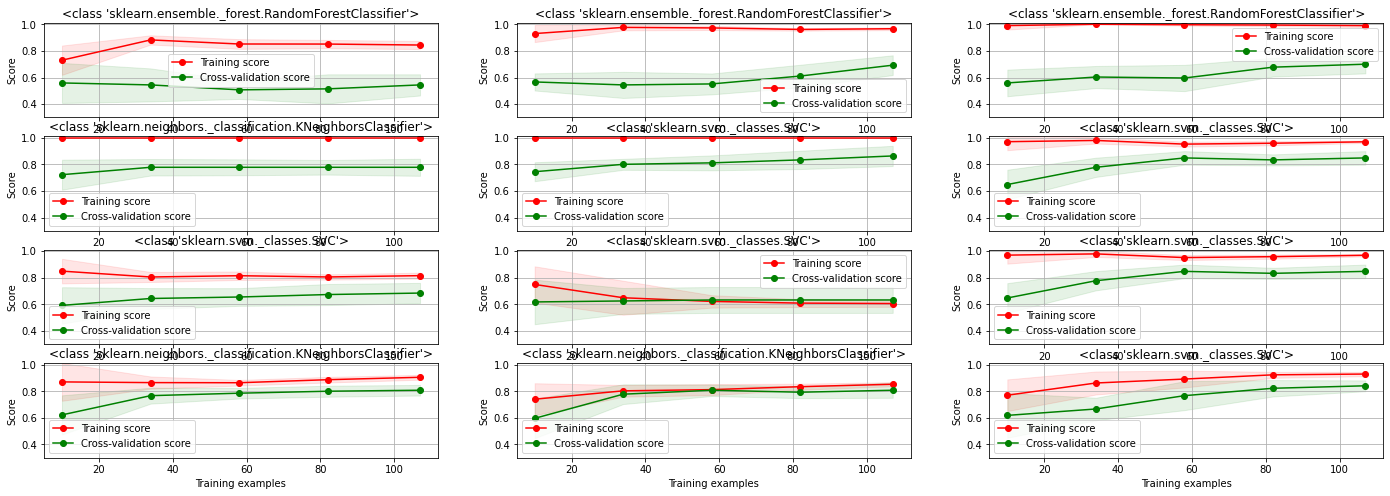

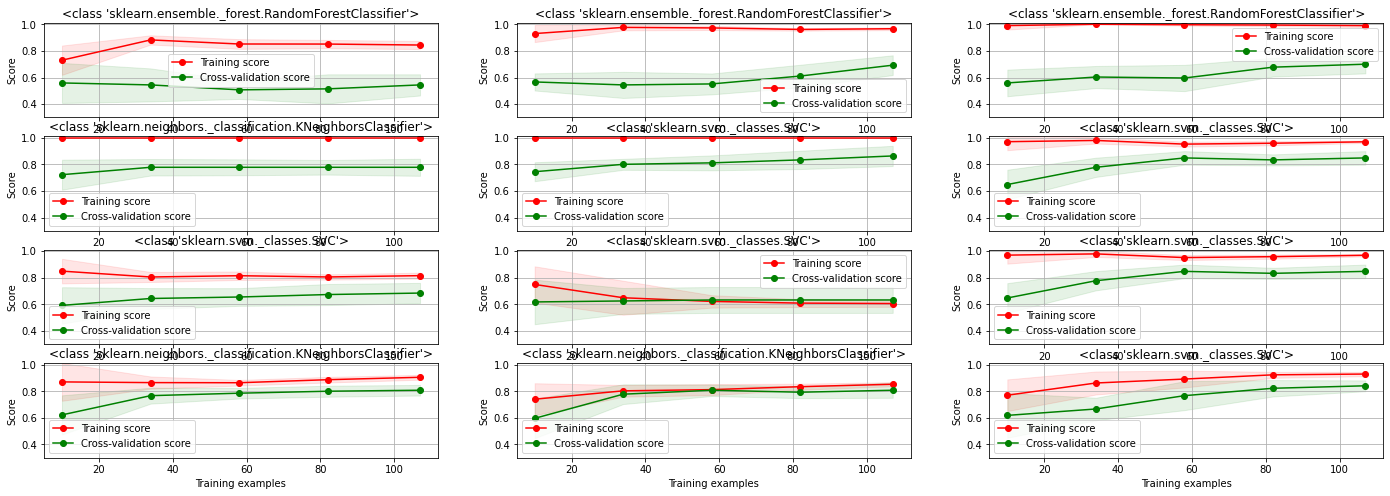

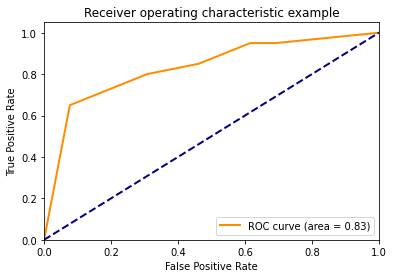

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


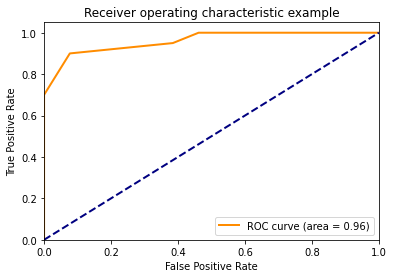

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Selected 350 from 700 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650155104890946, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650156127777528, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650155276478966, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.65015221847786, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.65015272976122, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650150759080812, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.65014961987335, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650150736454517, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650150814639527, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650149824916642, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650148954905614, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650149786437645, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650149689897312, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.6501500369071, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650149052697355, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650148801484633, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650149319956267, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650148946329743, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650149013974872, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650149029426277, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650148931037396, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650149016795822, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650149418492408, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650149668357603, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650149988617095, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650150098065431, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650150558732925, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650150932695652, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650151521676367, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.65015192417859, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650152704926189, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650153478248722, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650154316111632, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650155327353165, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650156449102127, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650157773393925, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650159204971231, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650160878113532, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650162807843884, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650164979081673, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.65016741716585, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650170227804711, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650173389632446, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650177002319069, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650181095475531, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650185748627596, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.650191022232757, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.62331849027531, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.62352171419862, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.623529445101354, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.623538220537693, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.623548170165495, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.62355946300017, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.830561317273187, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.560130158882497, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.560072151257401, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.790759867369658, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.369291273865805, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.370569583006052, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.146560735166087, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.302001971162124, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.293522754865869, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.293562401500722, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.293607238645386, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.638654882700362, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.637334107524833, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.34792361162554, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.394673269955454, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.33291448810347, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.724955120401795, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.625264918986804, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.990318551851356, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.120822396893843, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.298067952349044, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.224912821074682, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.045815577684287, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.930317693466101, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.768002856215928, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.53049423408073, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.58776176192455, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.19072469419276, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.223402813903713, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.639569216972749, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.640510377565299, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.105119817474026, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.823268140107206, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.414143980475302, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.186140385114541, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.511877262577542, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.961641342931436, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.454081370184575, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.511458991527327, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.716292563160874, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.110711957909668, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.556016496132987, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.815946334846934, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.854620609955113, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.377391768474247, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.663204067486483, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.57545028990825, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.322525248691417, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.666201785209267, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.7531842265630715, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.627434231283246, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.304435714919336, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.463289807040429, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.695835637935435, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.333807247043175, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8160772784222345, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.028610367649634, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.474397259377138, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.036751722471436, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9354314397573589, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7913993501958672, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.719709566787735, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8822932140609154, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.41722325127418, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4826484833412437, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9353049569205893, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4665347196145646, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20768668045635508, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09623676024258287, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0457431934474144, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04943683602594717, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.034408758782213056, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.038960030353315744, tolerance: 0.0082
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.044676831135525674, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01728806336034694, tolerance: 0.0082
  positive)


	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33
	 Misclassified: 33 / 33


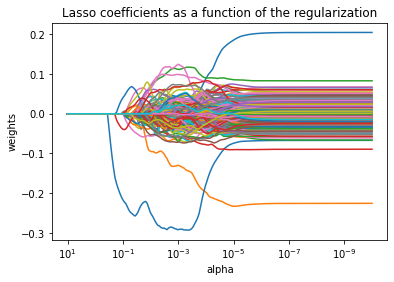

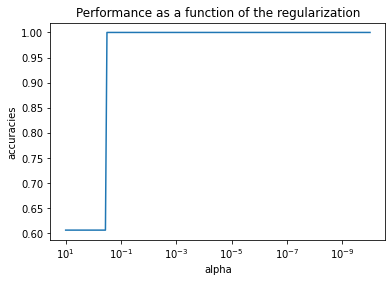

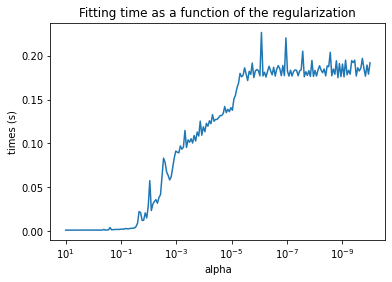

Selected 350 from 700 features.


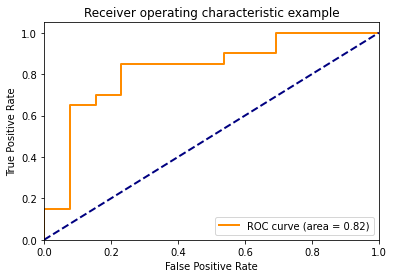

(134, 288)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


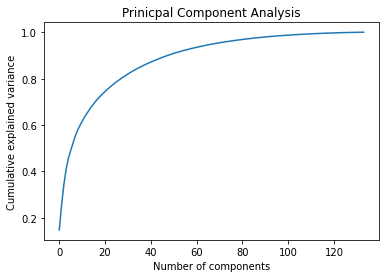

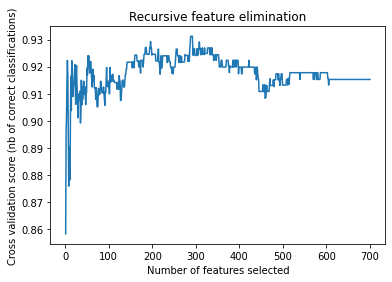

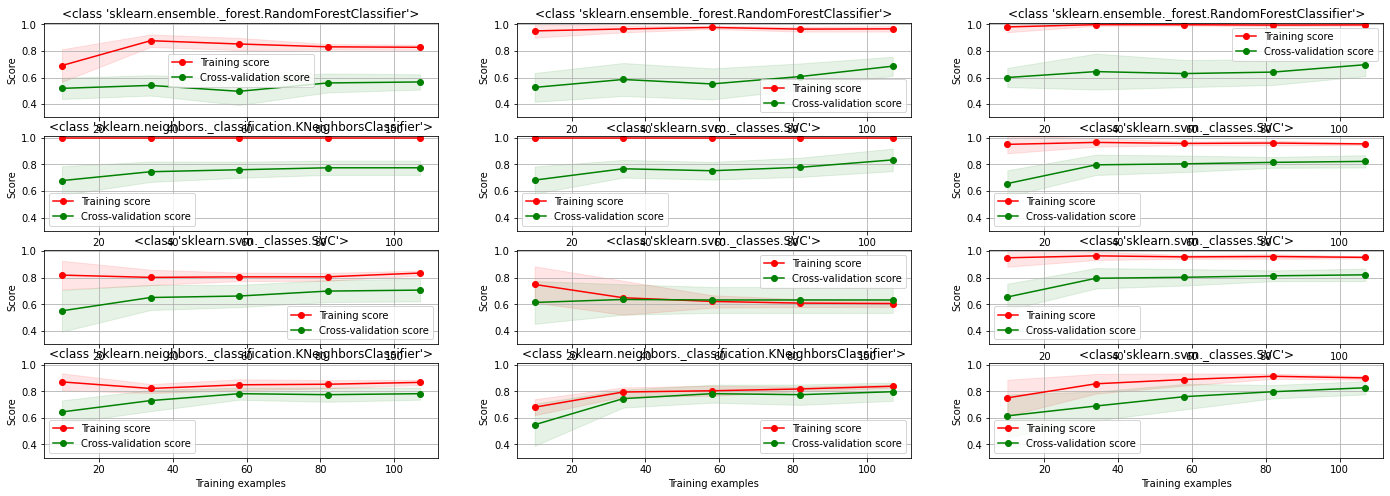

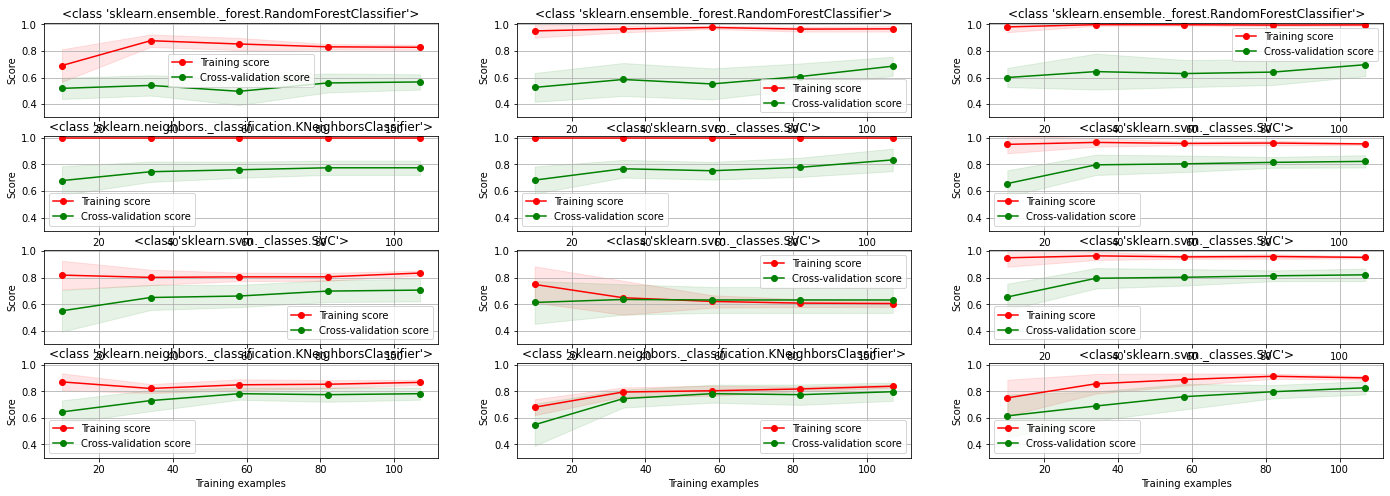

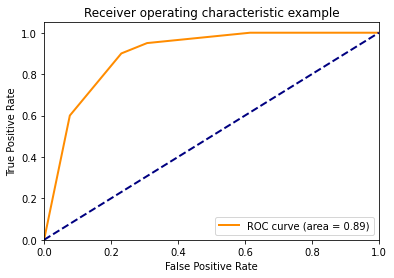

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


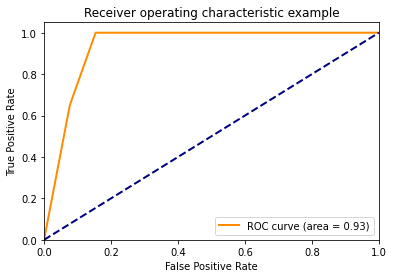

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Selected 350 from 700 features.
[0.7647058823529411, 0.7352941176470589, 0.8787878787878788, 0.7272727272727273, 0.7575757575757576]
[0.7352941176470589, 0.7352941176470589, 0.8787878787878788, 0.8181818181818182, 0.8181818181818182]
[0.7647058823529411, 0.8235294117647058, 0.9393939393939394, 0.8181818181818182, 0.7878787878787878]
[0.8823529411764706, 0.7941176470588235, 0.9696969696969697, 0.8787878787878788, 0.7575757575757576]
[0.7352941176470589, 0.8529411764705882, 0.9090909090909091, 0.8181818181818182, 0.6666666666666666]
accuracy knn and pca is 0.7727272727272728, auc knn and pca is 0.8424908424908425
accuracy svm and pca is 0.7971479500891266, auc svm and pca is 0.766098901098901
accuracy knn and rfecv is 0.8267379679144385, auc knn and rfecv is 0.9252564102564103
accuracy svm and rfecv is 0.85650623885918, auc svm and rfecv is 0.8461904761904762
accuracy L1 is 0.7964349376114083, auc L1 is 0.8549450549450549
The best performing combination of classifier and selection method

In [0]:
cv_5fold = model_selection.StratifiedKFold(n_splits=5)

results_accuracy_knn_pca = []
results_accuracy_knn_rfecv = []
results_accuracy_svm_pca = []
results_accuracy_svm_rfecv = []
results_accuracy_L1 = []

results_auc_knn_pca = []
results_auc_knn_rfecv = []
results_auc_svm_pca = []
results_auc_svm_rfecv = []
results_auc_L1 = []

x = data.drop(columns = ["label"])
y = data.label

# Feature selection
# Search for features with >60% missing data (NaN values)
missing = x.isnull().sum(axis = 0).reset_index()
missing.columns = ['column_name', 'missing_count']
missing = missing.loc[missing['missing_count']>(0.6*len(x.index))] 
print(f'The number of features that have more than 60% missing data is {missing.shape[0]}. The following features are removed:')
print(missing)

# Remove features >60% missing data (NaN values)
x = x.drop(missing['column_name'], axis=1, inplace=False)
print(x.shape)
    
x = x.to_numpy()
y = y.to_numpy()

for train_index, test_index in cv_5fold.split(x, y):
    
    # Create train and test feature matrices and label vectors
    X_train = x[train_index]
    y_train = y[train_index]
    X_test = x[test_index]
    y_test = y[test_index]

    # Perform KNN-imputing on train and test set
    [X_train_KNN_imputed, X_test_KNN_imputed] = missing_data(X_train,y_train)
    # Perform scaling on train and test set
    [X_train_scaled, X_test_scaled] = standard_scaler(X_train_KNN_imputed, X_test_KNN_imputed)

    # L1 Regularization (LASSO)
    regularization_lasso(X_train_scaled, X_test_scaled, y_train, y_test)
    X_train_lasso, X_test_lasso = select_from_module_lasso(X_train_scaled, X_test_scaled, y_train)
    # Fit LDA on selected features (LASSO)
    clf = LDA()
    clf.fit(X_train_lasso, y_train)
    y_score = clf.predict_proba(X_test_lasso)
    plot_roc_curve(y_score, y_test)

    # Perform PCA on train and test set
    [X_train_pca, X_test_pca] = pca(X_train_scaled, X_test_scaled)
    # Perform RFECV on train and test set
    [X_train_rfecv, X_test_rfecv] = rfecv_featureselection(X_train_scaled, X_test_scaled, y_train)

    # Create learning Curves
    learning_curve_two(X_train_pca, X_test_pca, y_train, y_test)
    learning_curve_two(X_train_rfecv, X_test_rfecv, y_train, y_test)

    # Calculate accuracies for all combinations of classifiers and selection methods
    [accuracy_knn_pca, auc_knn_pca] = optimalisation_knn(X_train_pca, X_test_pca, y_train, y_test)
    results_accuracy_knn_pca.append(accuracy_knn_pca)
    results_auc_knn_pca.append(auc_knn_pca)
    [accuracy_knn_rfecv, auc_knn_rfecv] = optimalisation_knn(X_train_rfecv, X_test_rfecv, y_train, y_test)
    results_accuracy_knn_rfecv.append(accuracy_knn_rfecv)
    results_auc_knn_rfecv.append(auc_knn_rfecv)
    [accuracy_svm_pca, auc_svm_pca] = optimalisatie_svm(X_train_pca,X_test_pca,y_train, y_test)
    results_accuracy_svm_pca.append(accuracy_svm_pca)
    results_auc_svm_pca.append(auc_svm_pca)
    [accuracy_svm_rfecv, auc_svm_rfecv] = optimalisatie_svm(X_train_rfecv,X_test_rfecv,y_train, y_test)
    results_accuracy_svm_rfecv.append(accuracy_svm_rfecv)
    results_auc_svm_rfecv.append(auc_svm_rfecv)
    [accuracy_L1, auc_L1] = lasso(X_train_scaled,X_test_scaled,y_train, y_test)
    results_accuracy_L1.append(accuracy_L1)
    results_auc_L1.append(auc_L1)

# Show all accuracies of classifiers and selection methods
print(results_accuracy_knn_pca)
print(results_accuracy_svm_pca)
print(results_accuracy_knn_rfecv)
print(results_accuracy_svm_rfecv)
print(results_accuracy_L1)

# Calculate mean accuracies for each classifier and selection method
final_accuracy_knn_pca = np.mean(results_accuracy_knn_pca)
final_auc_knn_pca = np.mean(results_auc_knn_pca)
print('accuracy knn and pca is {}, auc knn and pca is {}' .format(final_accuracy_knn_pca,final_auc_knn_pca ))

final_accuracy_svm_pca = np.mean(results_accuracy_svm_pca)
final_auc_svm_pca = np.mean(results_auc_svm_pca)
print('accuracy svm and pca is {}, auc svm and pca is {}'.format(final_accuracy_svm_pca, final_auc_svm_pca))

final_accuracy_knn_rfecv = np.mean(results_accuracy_knn_rfecv)
final_auc_knn_rfecv = np.mean(results_auc_knn_rfecv)
print('accuracy knn and rfecv is {}, auc knn and rfecv is {}'.format(final_accuracy_knn_rfecv, final_auc_knn_rfecv))

final_accuracy_svm_rfecv = np.mean(results_accuracy_svm_rfecv)
final_auc_svm_rfecv = np.mean(results_auc_svm_rfecv)
print('accuracy svm and rfecv is {}, auc svm and rfecv is {}'.format(final_accuracy_svm_rfecv, final_auc_svm_rfecv))

final_accuracy_L1 = np.mean(results_accuracy_L1)
final_auc_L1 = np.mean(results_auc_L1)
print('accuracy L1 is {}, auc L1 is {}'.format(final_accuracy_L1, final_auc_L1))

# Choose the best performing classifier and selection method
mean_accuracies = [np.mean(results_accuracy_knn_pca), np.mean(results_accuracy_svm_pca), np.mean(results_accuracy_knn_rfecv), np.mean(results_accuracy_svm_rfecv), np.mean(results_accuracy_L1)]
max_accuracy_index = mean_accuracies.index(max(mean_accuracies))
classifiers = ['knn and pca', 'svm and pca', 'knn and rfecv', 'svm and rfecv', 'L1 and LDA']
print(f'The best performing combination of classifier and selection method is {classifiers[max_accuracy_index]} with an accuracy of {mean_accuracies[max_accuracy_index]}.')